In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [3]:
train_dir = '/content/drive/MyDrive/Data/Data/Training'
test_dir = '/content/drive/MyDrive/Data/Data/Testing'

train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label , image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir,label ,image))
    test_labels.append(label)


test_paths , test_labels = shuffle(test_paths, test_labels)

In [4]:
#ImageProcessing

def augement_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
  image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
  return image


def open_images(paths):
  images = []
  for path in paths:
    image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = augement_image(image)
    images.append(image)
  return np.array(images)

def encode_label(labels):
  unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

def dataGen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [6]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')


for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# Train the model
history = model.fit(dataGen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 1990s 13s/step - loss: 1.0048 - sparse_categorical_accuracy: 0.5820
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - loss: 0.4361 - sparse_categorical_accuracy: 0.8397
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - loss: 0.3199 - sparse_categorical_accuracy: 0.8815
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - loss: 0.2615 - sparse_categorical_accuracy: 0.9044
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - loss: 0.1699 - sparse_categorical_accuracy: 0.9366


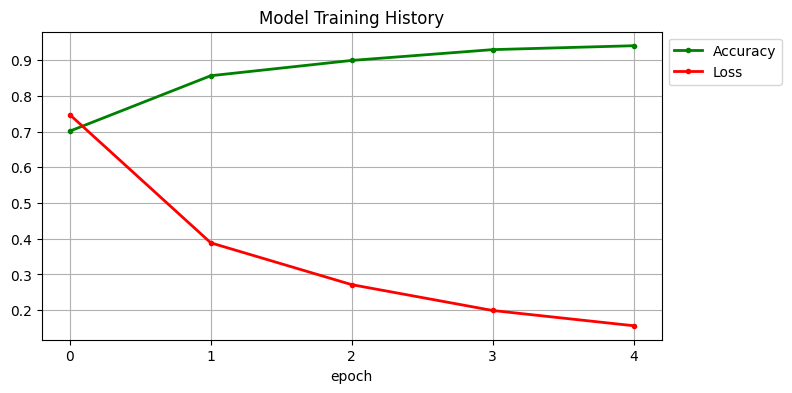

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [9]:
# Save the entire model
model.save('model.h5')


In [10]:

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


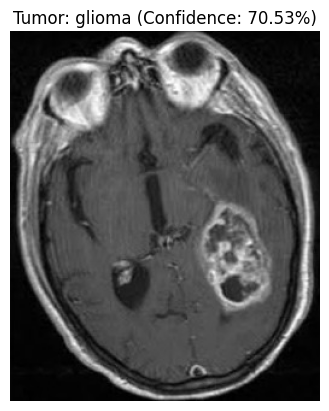

In [13]:

image_path = '/content/drive/MyDrive/Data/Data/Testing/meningioma_tumor/image(10).jpg'  # Provide the path to your new image
detect_and_display(image_path, model)